In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train = pd.read_csv('riiid-test-answer-prediction/train.csv', nrows=10**7)
test = pd.read_csv("riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("riiid-test-answer-prediction/questions.csv")

In [3]:
'''
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture
'''

'\nlecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).\npart: top level category code for the lecture.\ntag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.\ntype_of: brief description of the core purpose of the lecture\n'

In [4]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [5]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


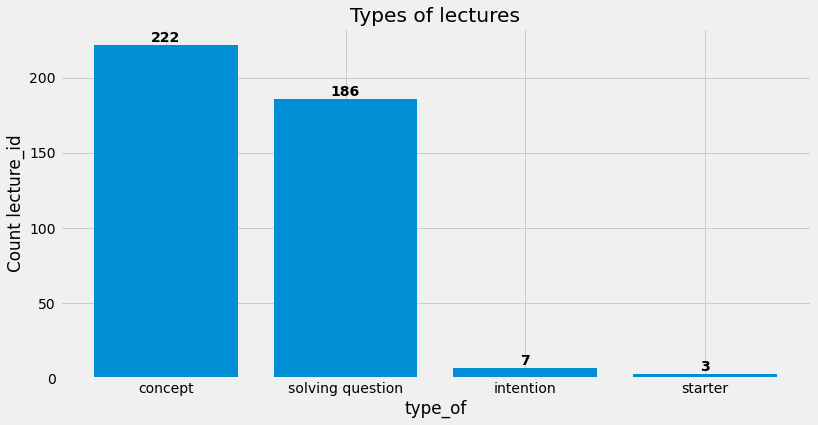

In [6]:
#강의 종류와 갯수 확인 (concept:222  solving question:86  intention:7  starter:3 )

lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

answered_correctly    -1      0      1
user_id                               
115                  NaN   14.0   32.0
124                  NaN   23.0    7.0
2746                 1.0    8.0   11.0
5382                 3.0   41.0   84.0
8623                 3.0   39.0   70.0
...                  ...    ...    ...
216740611            NaN   66.0  144.0
216741934            NaN   22.0   82.0
216743480            NaN   12.0    5.0
216747710            2.0   91.0   84.0
216747867           30.0  259.0  753.0

[39491 rows x 3 columns]
user_id
115           0
124           0
2746          1
5382          3
8623          3
             ..
216740611     0
216741934     0
216743480     0
216747710     2
216747867    30
Name: Lecture, Length: 39491, dtype: Int64
                   Wrong    Right
                     sum      sum
Watches_lecture                  
False             510364   682119
True             2836815  5775306
Watches_lecture
False    0.572016
True     0.670602
Name: Percent_corr

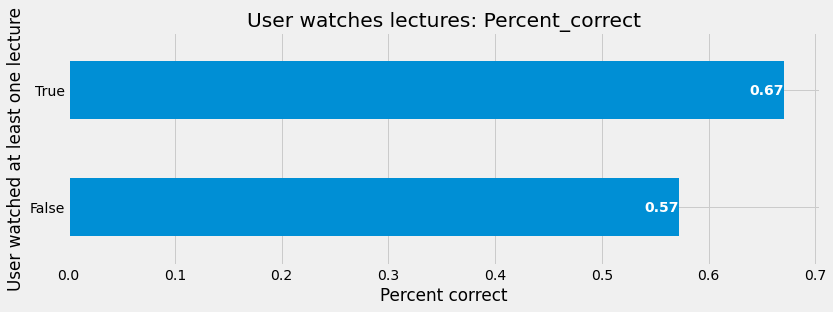

In [16]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
print(user_lect) # answered_correctly (-1, 0, 1)이 칼럼이 됨

user_lect.columns = ['Lecture', 'Wrong', 'Right'] #칼럼명 지정
user_lect['Lecture'] = user_lect['Lecture'].fillna(0) #-1값이 없는 사람(강의를 한번도 안들은 사람)은 값이 NaN이므로 0으로 채워줌
user_lect = user_lect.astype('Int64') #float -> int
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False) # user_lect.Lecture:강의를 들은 횟수 나타냄
                                        #user_lect.Lecture가 0보다 크면(강의를 1회 이상 들었으면) True, 아니면 False
                                #np.where(조건, 조건이 참일때 입력되는 값, 거짓일때 입력되는값)
print(user_lect.Lecture)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']}) #틀린문제, 맞은문제 sum
print(watches_l)

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
                            #강의안들은사람, 들은사람 각각 맞은문제/전체문제 (맞은문제의비율) 구해서 새로운 칼럼(Percent_correct)으로 추가
print(watches_l['Percent_correct']) #False:0.572016   True:0.670602

watches_l = watches_l.iloc[:,2] #watches_l의 칼럼 Wrong, Right, Percent_correct 중에 Percent_correct 만 가져옴

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [8]:
#추가 분석 필요

# batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
# print(batch_lect)

# batch_lect.columns = ['Lecture', 'Wrong', 'Right']
# batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
# batch_lect = batch_lect.astype('Int64')
# batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
# batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
# batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

# print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

answered_correctly   -1        0        1
task_container_id                        
0                   7.0  12660.0  27023.0
1                   1.0  18718.0  20986.0
2                   4.0  22347.0  17294.0
3                   3.0  18081.0  21568.0
4                   4.0  35906.0  33348.0
...                 ...      ...      ...
9995                NaN      5.0     10.0
9996                1.0      1.0     13.0
9997                NaN      3.0     10.0
9998                1.0      2.0     10.0
9999                NaN      4.0      9.0

[10000 rows x 3 columns]
The highest number of lectures watched within a single task_container_id is 523.


TypeError: float() argument must be a string or a number, not 'NAType'

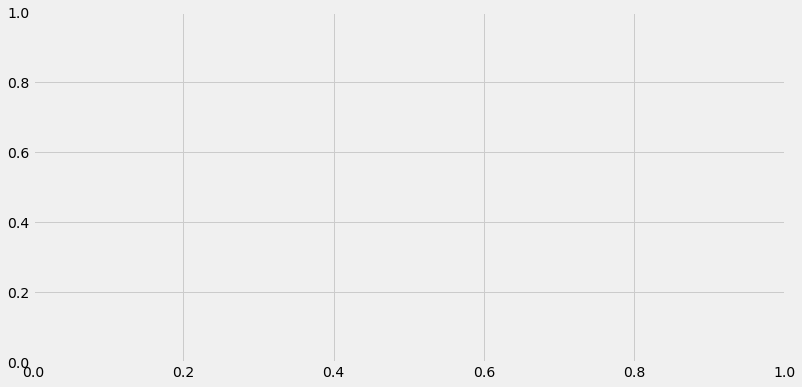

In [9]:
#추가 분석 필요
# batch = batch_lect.iloc[:, 3:]

# fig = plt.figure(figsize=(12,6))
# x = batch.Percent_lecture
# y = batch.Percent_correct
# plt.scatter(x, y, marker='o')
# plt.title("Percent lectures in a task_container versus percent answered correctly")
# plt.xticks(rotation=0)
# plt.xlabel("Percent lectures")
# plt.ylabel("Percent answered correctly")

# plt.show()

In [10]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 5979 task_container_ids with lectures and 4021 task_container_ids without lectures.


In [11]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

,Percent_correct
Has_lecture,
False,0.735944
True,0.656856
